<a href="https://colab.research.google.com/github/karthikkodakandla/dataset/blob/master/Transfer_second_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine Tuning with VGG16 for Flower classification on Jena Flower Data Set.

By Karthik Kodakandla

Used Jena Flower classification model to predict the classification of the flower based on the images. Used Fine tuning model which is pre trained using VGG16. The Architecture of VGG16 moel is as below:

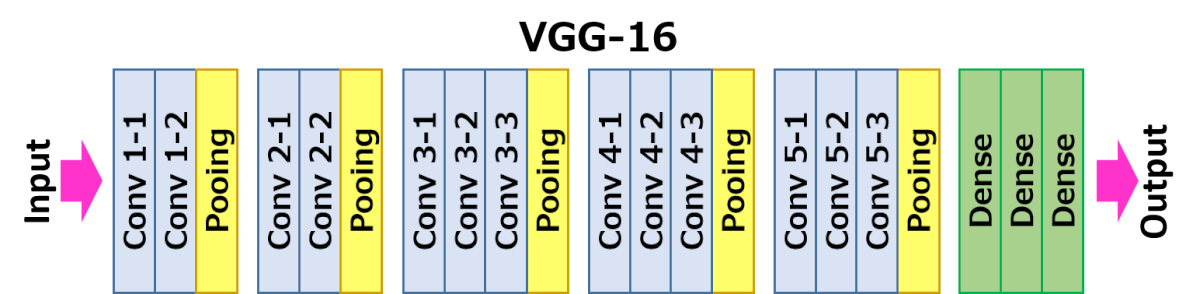

We took the weights of the last two layers and added to model which uses padding techniques,max pooling, batch normalization and the output with 30 classes using soft max


- From the Accuary plot, we can observe that Train and Validation accuracy has been increasing throughout the epochs.
- From the Loss plot also we can see that there was initially high validation error but later it smoothen out.
 

Overall the model with fine tuning is performing with 98.5% accuracy which is better than the normal CNN model which has 85% accuracy( first question). 

# Activating GPU and checking its utilization

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=b0bd4751ba4449f76e16fa3c1b24e322f6b68c501d620c446f132f4db2079886
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 112.3 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
try:
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  device='/gpu:0'
except:
  device='/cpu:0'

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Libraries

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras import Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Images Classification - Train and Test

## Using given 'classlabels' file for mapping

In [6]:
#getting given 'class labels'
class_labels = pd.read_csv('/content/drive/My Drive/Flower_images/Flower_image/classlabels.txt',sep=',',header=None)
class_labels.columns = ['image_name','class_label']
print("Flowers Label \n",class_labels.head())

#extarcting images numbers from given images
class_labels['image_num'] = class_labels['image_name'].apply(lambda image_name:image_name[4:9])
class_labels['image_num'] = class_labels['image_num'].astype(int)

Flowers Label 
       image_name  class_label
0  JFT_00001.jpg            1
1  JFT_00002.jpg            1
2  JFT_00003.jpg            1
3  JFT_00004.jpg            1
4  JFT_00006.jpg            1


## Using given 'train1' file to get the set of Training Images

In [7]:
#getting given 'train split images numbers'
train_images_label = pd.read_csv('/content/drive/My Drive/Flower_images/Flower_image/trn1.txt',sep=',',header=None)
train_images_label.columns = ['image_num_train']
print("\n Train Images Numbers \n",train_images_label.head())


 Train Images Numbers 
    image_num_train
0                2
1                4
2                9
3               10
4               21


## Creating flag of "Train" and "Test" images in "classlables"

In [8]:
#creating flag to identify which images belong to test and train
images_data = pd.merge(class_labels, train_images_label, how='left', left_on='image_num', right_on='image_num_train')
images_data['train_test_flag'] = 'test'
images_data.loc[images_data['image_num_train'].isna(),'train_test_flag'] = 'train'
#images_data.head()
images_data = images_data.drop('image_num_train',axis=1)
images_data.head()

,image_name,class_label,image_num,train_test_flag
0,JFT_00001.jpg,1,1,train
1,JFT_00002.jpg,1,2,test
2,JFT_00003.jpg,1,3,train
3,JFT_00004.jpg,1,4,test
4,JFT_00006.jpg,1,6,train


In [9]:
images_data['train_test_flag'].value_counts()

train    1200
test      279
Name: train_test_flag, dtype: int64

# Processing the Images to place them in required Train & Test folder

## Unzip flowers images from Google Drive

In [10]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [11]:
from colab_util import *
drive_handler = GoogleDriveHandler()

In [12]:
!unzip -qq '/content/drive/My Drive/Colab Notebooks/JF30-1.zip'


In [13]:
data_dir = '/content/jpg'
output_dir = '/content/drive/My Drive/Flowers'
train_path = output_dir + '/train/'
test_path = output_dir + '/test/'

In [ ]:

# !rm -rf '/content/drive/My Drive/ content drive My Drive Flowers train 29'

In [14]:
for i in range(1,31):
  drive_handler.create_folder(str(i),parent_path='Flowers/train')
  drive_handler.create_folder(str(i),parent_path='Flowers/test')


## Code to segregate the train/test images and put them in each of their class folder

In [15]:
#Code to segregate the train/test images and put them in each of their class folder
for i in images_data.index.values:
    train_test_flag = images_data.loc[i,'train_test_flag']
    class_label = images_data.loc[i,'class_label']
    image_name = images_data.loc[i,'image_name']
    input = data_dir + '/' + image_name
    output = output_dir + '/' + train_test_flag + '/' + str(class_label)
    shutil.copy(input, output)



## Setting the required directories to access images

## Reviewing the images from repective folders

JFT_00001.jpg
(962, 911, 3)


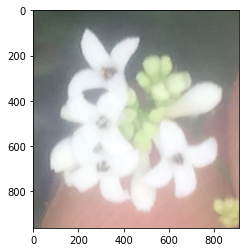

In [16]:
#2. Reviewing the train images of class 1
print(os.listdir(train_path+'1')[0])
class_1_train = train_path+'1'+'/JFT_00001.jpg'
class_1_train
imread(class_1_train)
print(imread(class_1_train).shape)
plt.imshow(imread(class_1_train));

JFT_00021.jpg
(1000, 953, 3)


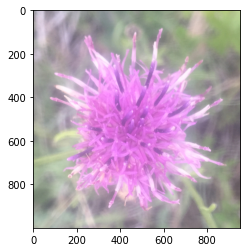

In [17]:
#3. Reviewing the test images of class 1
print(os.listdir(test_path+'/2')[0])
class_2_test = test_path+'/2'+'/JFT_00021.jpg'
class_2_test
imread(class_2_test)
print(imread(class_2_test).shape)
plt.imshow(imread(class_2_test));

## Setting up the input shape of images for the model

In [18]:
image_shape = (200,200,3)

# ImageDataGenerator for Train Images

Image before transformation


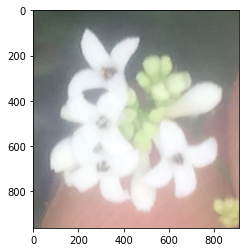

In [19]:
print("Image before transformation")
plt.imshow(imread(class_1_train));

Image after transformation


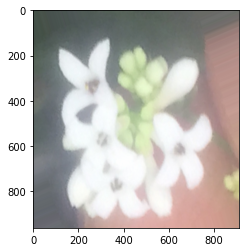

In [20]:
#3. manipulating the images for building the model later
image_gen_train = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 0.1
                               height_shift_range=0.10, # Shift the pic height by a max of 0.1
                               #rescale=1./255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
img = imread(class_1_train)
print("Image after transformation")
plt.imshow(image_gen_train.random_transform(img));

Test Image with no transformation


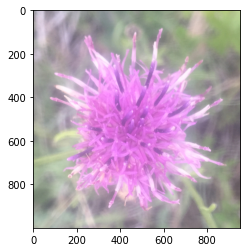

In [21]:
#for testing
image_gen_test = ImageDataGenerator()
img = imread(class_2_test)
print("Test Image with no transformation")
plt.imshow(image_gen_test.random_transform(img));

## Setting up of a directory to flow batches from directory

In [22]:
#4. Setting up of a directory to flow batches from directory
image_gen_train.flow_from_directory(train_path)
image_gen_test.flow_from_directory(test_path)

Found 1200 images belonging to 30 classes.
Found 279 images belonging to 30 classes.


In [23]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Building the Model

In [24]:
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
def create_model():
  vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=image_shape)
  
  for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

  model = Sequential()

  model.add(vgg_conv)
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(BatchNormalization())
  
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Dense(30, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)

  return model

with tf.device('/gpu:0'): # creating the model in the GPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 512)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18432)             73728     
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_______________________________________________________

## Setting up the Batch Size

In [25]:
#Batch size
batch_size = 16 #* tpu_strategy.num_replicas_in_sync

## Using Image Generator for Train Images and Class Labels

In [26]:
train_image_gen = image_gen_train.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

train_image_gen.class_indices

Found 1200 images belonging to 30 classes.


{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '23': 15,
 '24': 16,
 '25': 17,
 '26': 18,
 '27': 19,
 '28': 20,
 '29': 21,
 '3': 22,
 '30': 23,
 '4': 24,
 '5': 25,
 '6': 26,
 '7': 27,
 '8': 28,
 '9': 29}

In [27]:
train_steps = len(train_image_gen)
train_steps

75

In [28]:
test_image_gen = image_gen_test.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)


Found 279 images belonging to 30 classes.


In [29]:
valid_steps = len(test_image_gen)
valid_steps

18

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

## Model Fit using fit_generator

In [31]:
#early_stop = EarlyStopping(monitor='val_loss',patience=2)
model_history = model.fit_generator(
    generator=train_image_gen, 
    steps_per_epoch=train_steps,   
    epochs=20, 
    validation_steps=valid_steps,
    validation_data=test_image_gen,
    #callbacks=[early_stop]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
75/75 [==============================] - 36s 487ms/step - loss: 1.8358 - acc: 0.5242 - val_loss: 3.8122 - val_acc: 0.6201
Epoch 2/20
75/75 [==============================] - 36s 477ms/step - loss: 0.5838 - acc: 0.8308 - val_loss: 0.6875 - val_acc: 0.8387
Epoch 3/20
75/75 [==============================] - 36s 480ms/step - loss: 0.3817 - acc: 0.8783 - val_loss: 0.3165 - val_acc: 0.9104
Epoch 4/20
75/75 [==============================] - 36s 476ms/step - loss: 0.3185 - acc: 0.8992 - val_loss: 0.2900 - val_acc: 0.8925
Epoch 5/20
75/75 [==============================] - 36s 477ms/step - loss: 0.2758 - acc: 0.9033 - val_loss: 0.3008 - val_acc: 0.9176
Epoch 6/20
75/75 [==============================] - 36s 475ms/step - loss: 0.1787 - acc: 0.9450 - val_loss: 0.2541 - val_acc: 0.9462
Epoch 7/20
75/75 [==============================] - 36s 477ms/step - loss: 0.1691 - acc: 0.9425 - val_loss: 0.2912 - val_acc: 

## Plotting the accuracy of model

In [32]:
losses = pd.DataFrame(model.history.history)
losses.head()

,loss,acc,val_loss,val_acc
0,1.835767,0.524167,3.812181,0.620072
1,0.583819,0.830833,0.687489,0.838710
2,0.381695,0.878333,0.316497,0.910394
3,0.318521,0.899167,0.289973,0.892473
4,0.275778,0.903333,0.300831,0.917563


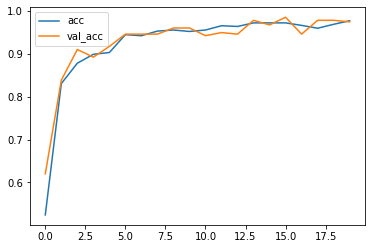

In [33]:
losses[['acc','val_acc']].plot()

## Plotting the errors of model

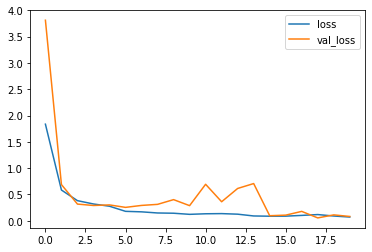

In [34]:
losses[['loss','val_loss']].plot()

In [40]:
max(model_history.history['val_acc']) # Maximum accuracy achieved through the model

0.9856630563735962

# Evaluation of Model

In [35]:
#7. Evaluate Model on Test History
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.08123229444026947, 0.9749103784561157]

# Predictions

In [36]:
#8. Predicions and Evaluate
pred = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [37]:
predictions  = []
for each in range(len(pred)):
  predictions.append(np.argmax(pred[each]))
len(predictions)

279

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.91      1.00      0.95        10
           2       0.91      1.00      0.95        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       0.77      1.00      0.87        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

# Conclusion